In [1]:
#Written by Tim de Wild, code to reproduce Fig. 1 of 1506.04152. Our definition of variable C3 is their C2'. 

import camb
import numpy as np
import time
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy.integrate import quad
from scipy.signal import argrelextrema

In [2]:
#array of z values
z=10**np.linspace(0,4,10000)
zint=10**np.linspace(4,0,200)
zz=10**np.linspace(0,3,2000)

a=10**np.linspace(-4,0,1000)

In [3]:
#set up a new set of parameters for CAMB
pars = camb.CAMBparams()

#this function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
# pars.set_cosmology(H0=100*h, ombh2=Obh2, omch2=Ocdmh2, mnu=0.06, omk=0, tau=0.06)
# pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars=camb.set_params(H0=67.32117, ombh2= 0.0223828, omch2= 0.1201075, tau =0.05430842,
                     As= 2.100549e-9, ns= 0.9660499)

pars.Do21cm  =True

pars.Evolve_delta_xe =True # ionization fraction perturbations
pars.Evolve_baryon_cs  = True # accurate baryon perturbations
pars.WantCls =False
pars.SourceTerms.use_21cm_mK = False # Use dimensionless rather than mK units
redshifts=[30,50,100] # The red-shifts in use in the paper, can change if you want
pars.set_matter_power(kmax=1000., redshifts=redshifts)

# get baryon_etc-transfer functions
results= camb.get_results(pars)
trans = results.get_matter_transfer_data()

def scal_pow(k):
    As = 2.100549e-09
    ns = 0.9660499
    kpivot = 0.05
    pfactor = As*kpivot**(1.-ns)
    return pfactor*k**(ns-1.)

scal_pow(.3), pars.scalar_power(.3)

#calculate results for these parameters


#calculate results with initial values from ini21cm
#pars21 = camb.read_ini("inifiles/params.ini")
#results21 = camb.get_results(pars21)

Note: redshifts have been re-sorted (earliest first)


(1.976580489113523e-09, 1.976580489113523e-09)

In [4]:
#parameters
h=pars.h
T0 = pars.TCMB
Yp = pars.get_Y_p()
xHe = Yp/(4*(1-Yp))

Alpha=1.84299228e-22 #per second per Kelvin
Beta=2.0580455e14 #m3 K/s^2 hbar c^3/kb
kmperMpc=3.241e-20 #value km/Mpc 
rho_crit_0=1.8788e-26*h**2 #in kg/m3

Obh2=ombh2= pars.ombh2

Ocdmh2=pars.omch2
Omh2=Obh2+Ocdmh2

mp=1.672621911e-27 #mass proton in kg. 
nH0=(1-Yp)*Obh2/h**2/mp*rho_crit_0 #hydrogen density today (z=0) in m-3

A10=2.85e-15 #hyperfine decay rate per second
Tstar=0.068169 #delta E12/kb in kelvin
v21=1420.4e6 #per second Hz

H0s=100*h*kmperMpc
c=299792458 #speed of light in meters per second
hp=6.62607015e-34
kb=1.38064852e-23
me=9.109383632e-31
lalpha = 121.5682e-9
E2s = 5.45e-19
E21 = 1.634e-18
Lambda2s1s=8.22458

#recombination coefficient
a_alpha=4.309e-19 #in m3/s
b_rec=-0.6166
c_rec=0.6703
d_rec=0.5300

In [5]:
def xe(z):
    if np.isscalar(z):
        return results.get_background_redshift_evolution([z],['x_e'],format='array').item()
    else:
        return np.asarray(results.get_background_redshift_evolution(z,['x_e'],format='array')).flatten()

def Tm(z):
    if np.isscalar(z):
        return results.get_background_redshift_evolution([z],['T_b'],format='array').item()
    else:
        return np.asarray(results.get_background_redshift_evolution(z,['T_b'],format='array')).flatten()

def Tgamma(z): return T0*(1+z)    
    
def Tg(z):
    Tg_vec=np.vectorize(Tgamma)
    if np.isscalar(z):
        return Tgamma(z)
    else:
        return Tg_vec(z)

def TmTg(z):
    return Tm(z)/Tg(z)

def H(z): 
    return kmperMpc*results.hubble_parameter(z)

def r(z):
    return results.comoving_radial_distance(z, tol=0.0001)

def Gamma_c(z):
    return (8/3)*Alpha*(Tg(z))**4*xe(z)/(1+xe(z)+xHe)

def rat(z):
    return (Tg(z)/Tm(z))*(Gamma_c(z)/H(z))

def Gamma_cH(z):
    return Gamma_c(z)/H(z)

#hard cutoff to exclude effects of rionization
def Gamma_cHc(z):
    return np.where(z<11, 0.002257317041612329, Gamma_cH(z))

#Include hard cutoff to exclude the effects of reionization
def ratc(z):
    return np.where(z<11, 0.023811101046805755, rat(z))
    

def zofa(a): return 1/a-1
def aofz(z): return 1/(1+z)



def kHH(Tm):                                           
    return 3.1e-17*Tm**0.357*np.exp(-32/Tm)            #fits kHH in m3/s for Tm in K, used in 1312.4948, from 0510814 

def kHe(Tm):
    return 1e-6*10**(-9.607+0.5*np.log10(Tm)*np.exp(-(np.log10(Tm))**4.5/1800)) #fits kHe in m3/s

def kHp(Tm):                                           
    return 3.2*kHH(Tm)

def nH(z):                                 #total H density nH=nHi+np
    return nH0*(1+z)**3

def ne(z):
    return xe(z)*nH(z)

def nHI(z):
    return nH(z)*(1-xe(z))                 #neutral H density nHI=nH(1-xe)

def C10(z):         
    return kHH(Tm(z))*nHI(z)      #rate per second, we have defined the neutral fraction as nH(z)*(1-xe(z)). 

def Yc(z):
    return C10(z)*Tstar/A10/Tm(z)

def Ts(z):
    return (Tg(z)+Yc(z)*Tm(z))/(1+Yc(z))

def T21(z):
    return (3/16)*(Beta/v21**2)*(A10/H(z))*nHI(z)/(1+z)*(1-Tg(z)/Ts(z))

def tt(z):
    return Tm(z)/10**4

#case B recombination rate, see Eq. 70 in astro-ph/9912182v2 
def alphaB(z):
    return a_alpha*tt(z)**b_rec/(1+c_rec*tt(z)**d_rec) #in m3/s

def betaB(z):
    return alphaB(z)*(2*np.pi*me*kb*Tm(z)/hp**2)**(3/2)*np.exp(-E2s/(kb*Tm(z)))

def KK(z):
    return lalpha**3/(8*np.pi*H(z))

def Cpeebles(z):
    return (1+KK(z)*Lambda2s1s*nH(z)*(1-xe(z)))/(1+KK(z)*Lambda2s1s*nH(z)*(1-xe(z))+KK(z)*betaB(z)*nH(z)*(1-xe(z)))

#auxilary function
def g(z):
    return (b_rec+c_rec*(b_rec-d_rec)*tt(z)**d_rec)/(1+c_rec*tt(z)**d_rec)

#effective recombination rate
def Gamma_r(z):
    return nH(z)*xe(z)*alphaB(z)

#ratio Gamma_r/H
def Gamma_rH(z):
    return Gamma_r(z)/H(z)

#hard cutoff to exclude effects of rionization
def Gamma_rHc(z):
    return np.where(z<11, Gamma_rH(11), Gamma_rH(z))

#mean baryonic speed of sound
def cs(z):
    return np.sqrt(5/3*kb*Tm(z)/(1.22*mp))

minMpc=3.24078e-23

#Jeans scale kmode kJ in 1/Mpc
def kJ(z):
    return np.sqrt(3/2)*H(z)/(1+z)/cs(z)/minMpc

#Horizon scale kH in 1/Mpc
def kH(z):
    return H(z)/c/(1+z)/minMpc


#heating rate photo-ionization/recombination
def qrec(z):
    return -3/2*(1+z)*H(z)*nH(z)*kb*Tm(z)*np.gradient(xe(z),z)

def qcomp(z):
    return 3/2*nH(z)*(1+xe(z)+xHe)*Gamma_c(z)*(Tg(z)-Tm(z))

def qadiab(z):
    return 3*H(z)*nH(z)*(1+xe(z)+xHe)*kb*Tm(z)

def ratio_bc(z):
    return 1-3*(1+z)/1001+2*((1+z)/1001)**1.5



array([ 1.42774610e+00,  2.82514985e+02, -3.25194013e+03])

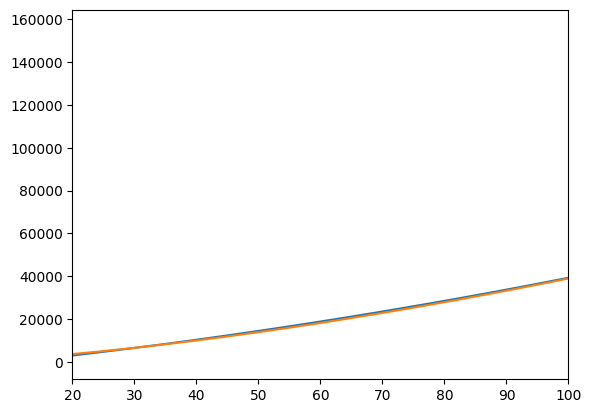

In [12]:
z = np.linspace(10,250)
res = np.polyfit(z,results.hubble_parameter(z),2)
plt.plot(z,z*z*res[0] + z*res[1] + res[2])
plt.plot(z,results.hubble_parameter(z))
plt.xlim(20,100)
# plt.ylim(0.0,0.2)
res

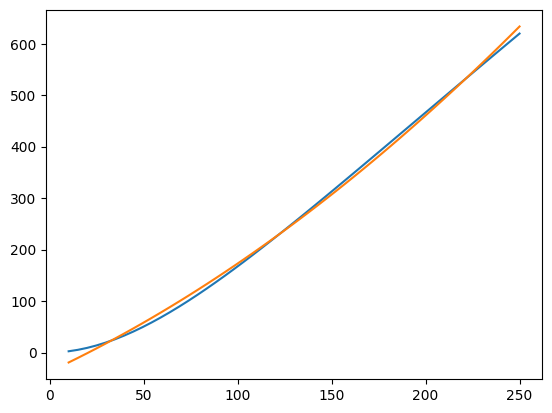

In [13]:
plt.plot(z,Tm(z))
res= np.polyfit(z,Tm(z),2)
plt.plot(z,z*z*res[0] + z*res[1] + res[2])

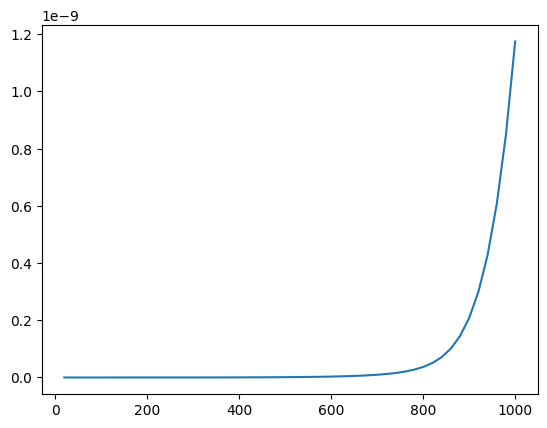

In [14]:
z = np.linspace(20,1000)
plt.plot(z,Gamma_c(z))

(10, 1000)

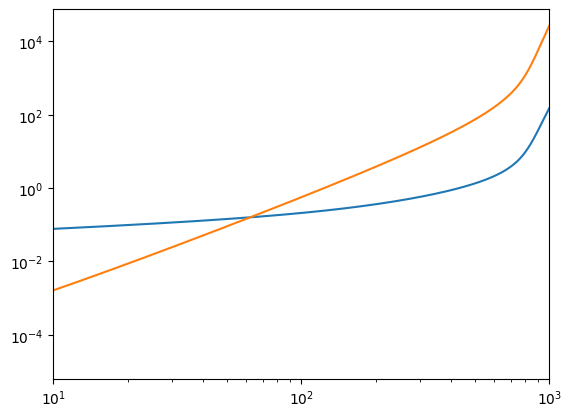

In [15]:
plt.plot(zz,Gamma_rH(zz))
plt.plot(zz,Gamma_cH(zz))
plt.xscale('log')
plt.yscale('log')
plt.xlim(10,1000)

/tmp/ipykernel_329140/223593998.py:58: RuntimeWarning: invalid value encountered in power
  return 1e-6*10**(-9.607+0.5*np.log10(Tm)*np.exp(-(np.log10(Tm))**4.5/1800)) #fits kHe in m3/s


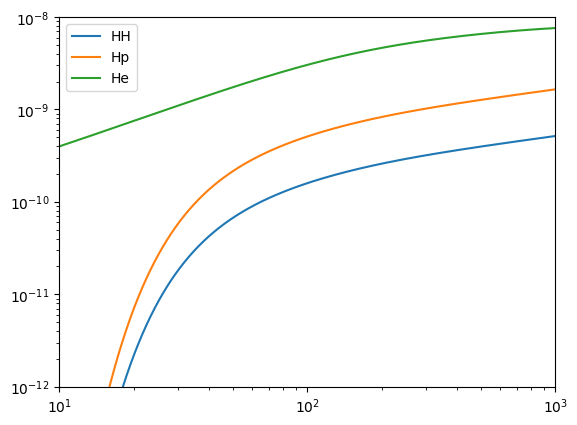

In [16]:
plt.plot(zz,1e6*kHH(Tm(zz)),label='HH')
plt.plot(zz,1e6*kHp(Tm(zz)),label='Hp')
plt.plot(zz,1e6*kHe(Tm(zz)),label='He')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10,1000)
plt.ylim(1e-12,1e-8)
plt.legend()

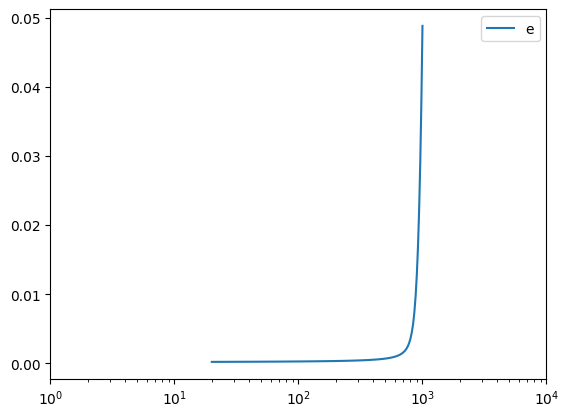

In [17]:
plt.plot(z,xe(z),label='e')
plt.xscale('log')
#plt.yscale('log')
plt.xlim(1,10000)
#plt.ylim(1e-12,1e-8)
plt.legend()

In [18]:
ZINT=10**np.linspace(4,0,400)

datatest=np.column_stack((ZINT,xe(ZINT),1e6*kHH(Tm(ZINT)),1e6*kHp(Tm(ZINT)),1e6*kHe(Tm(ZINT))))
datatest[datatest<1e-50]=0.
np.nan_to_num(datatest)
np.savetxt('colldata.csv', datatest, delimiter=',')


ratesdata=np.column_stack((ZINT,1/(3.154e7*nH(ZINT)*kHH(Tm(ZINT))),1/(3.154e7*A10*Tgamma(ZINT)/Tstar),1/(3.154e7*H(ZINT))))
np.savetxt('ratesdata.csv', ratesdata, delimiter=',')


/tmp/ipykernel_329140/223593998.py:58: RuntimeWarning: invalid value encountered in power
  return 1e-6*10**(-9.607+0.5*np.log10(Tm)*np.exp(-(np.log10(Tm))**4.5/1800)) #fits kHe in m3/s


(1.0, 10000000000.0)

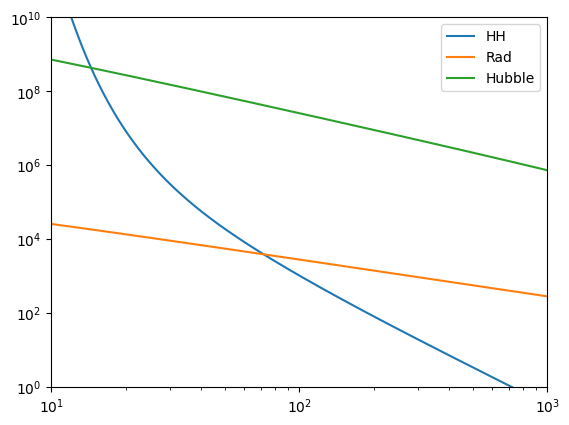

In [19]:
plt.plot(zz,1/(3.154e7*nH(zz)*kHH(Tm(zz))),label='HH')
plt.plot(zz,1/(3.154e7*A10*Tgamma(zz)/Tstar),label='Rad')
plt.plot(zz,1/(3.154e7*H(zz)),label='Hubble')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10,1000)
plt.legend()
plt.ylim(1e0,1e10)

(0.7079457843841379, 1412.537544622754)

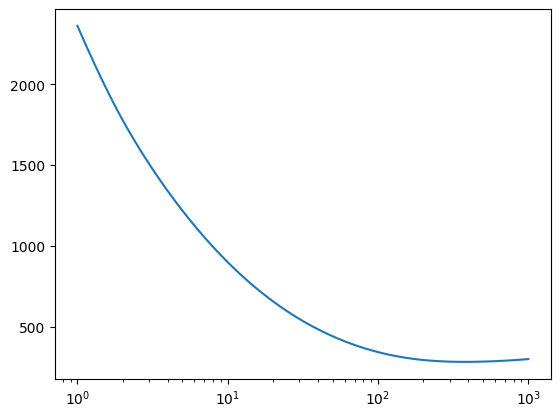

In [20]:
plt.plot(zz,kJ(zz))
plt.xscale('log')
plt.xlim()

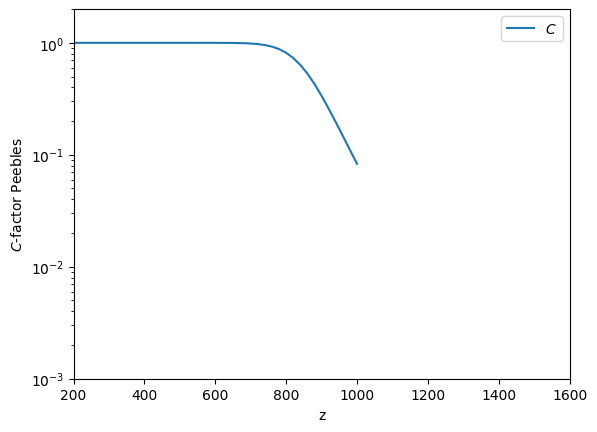

In [21]:
plt.plot(z,Cpeebles(z),label='$C$')
plt.xlim(200,1600)
plt.ylim(0.001,2)
plt.yscale('log')
plt.xlabel('z')
plt.ylabel('$C$-factor Peebles')
plt.savefig("Cpeebles.png", dpi=300)
plt.legend()


In [22]:
#compute (linear) transfer functions
Z = 10**np.linspace(0,4,300)
ks = [0.01,1,100,300]
ev = results.get_redshift_evolution(ks, Z, ['delta_baryon','delta_cdm'])

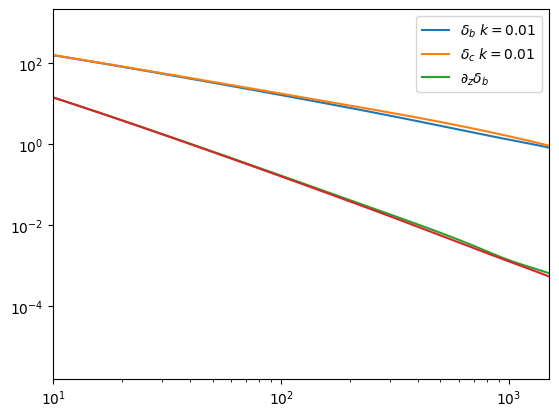

In [23]:
plt.plot(Z,ev[0,:,0],label='$\\delta_b$ $k=0.01$')
plt.plot(Z,ev[0,:,1],label='$\\delta_c$ $k=0.01$')
plt.plot(Z,abs(np.gradient(ev[0,:,0],Z)),label='$\\partial_z \\delta_b$')
plt.plot(Z,ev[0,:,0]/(1+Z))
plt.xscale('log')
plt.xlim(10,1500)
plt.yscale('log')
plt.legend()

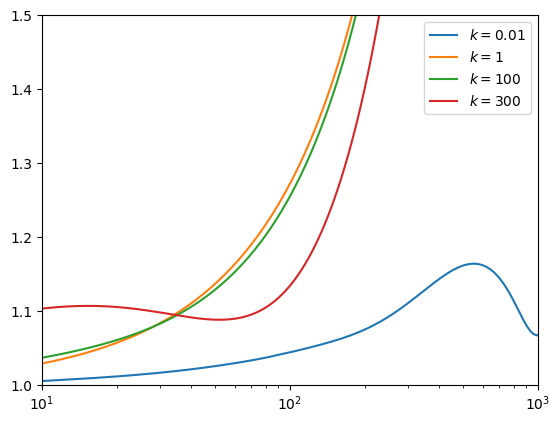

In [24]:
plt.plot(Z,abs(np.gradient(ev[0,:,0],Z))/(ev[0,:,0]/(1+Z)),label='$k=0.01$')
plt.plot(Z,abs(np.gradient(ev[1,:,0],Z))/(ev[1,:,0]/(1+Z)),label='$k=1$')
plt.plot(Z,abs(np.gradient(ev[2,:,0],Z))/(ev[2,:,0]/(1+Z)),label='$k=100$')
plt.plot(Z,abs(np.gradient(ev[3,:,0],Z))/(ev[3,:,0]/(1+Z)),label='$k=300$')
#plt.plot(Z,abs(np.gradient(ev[4,:,0],Z))/(ev[4,:,0]/(1+Z)),label='$k=300$')
#plt.plot(Z,abs(np.gradient(ev[5,:,0],Z))/(ev[5,:,0]/(1+Z)),label='$k=500$')
plt.xscale('log')
plt.xlim(10,1000)
plt.ylim(1,1.5)
plt.legend()

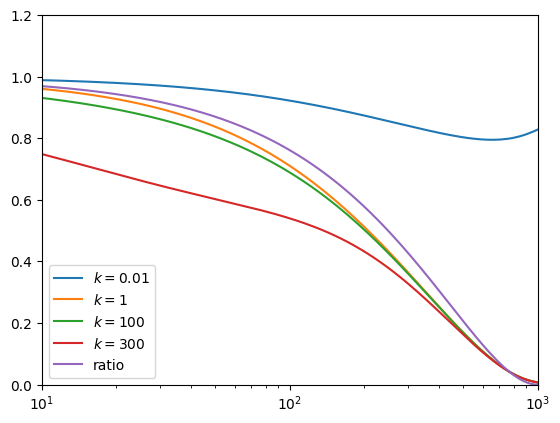

In [25]:
plt.plot(Z,ev[0,:,0]/ev[0,:,1],label='$k=0.01$')
plt.plot(Z,ev[1,:,0]/ev[1,:,1],label='$k=1$')
plt.plot(Z,ev[2,:,0]/ev[2,:,1],label='$k=100$')
plt.plot(Z,ev[3,:,0]/ev[3,:,1],label='$k=300$')
plt.plot(Z,ratio_bc(Z),label='ratio')
#plt.plot(Z,ev[4,:,0]/ev[4,:,1],label='$k=100$')
#plt.plot(Z,ev[5,:,0]/ev[5,:,1],label='$k=300$')
plt.xscale('log')
plt.xlim(10,1000)
plt.ylim(0,1.2)
plt.legend()

In [26]:
dbdcdata=np.column_stack((Z,ev[0,:,0]/ev[0,:,1],ev[1,:,0]/ev[1,:,1],ev[2,:,0]/ev[2,:,1],ev[3,:,0]/ev[3,:,1],ratio_bc(Z)))
np.savetxt('dbdcdata.csv',dbdcdata, delimiter=',')

In [27]:
d001=abs(np.gradient(ev[0,:,0],Z))/(ev[0,:,0]/(1+Z))
d1=abs(np.gradient(ev[1,:,0],Z))/(ev[1,:,0]/(1+Z))
d100=abs(np.gradient(ev[2,:,0],Z))/(ev[2,:,0]/(1+Z))
d300=abs(np.gradient(ev[3,:,0],Z))/(ev[3,:,0]/(1+Z))

dbdcdotdata=np.column_stack((Z,d001,d1,d100,d300))
np.savetxt('dbdcdotdata.csv',dbdcdotdata, delimiter=',')

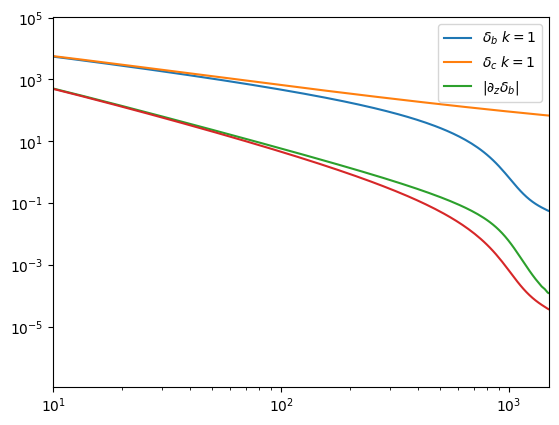

In [28]:
plt.plot(Z,ev[1,:,0],label='$\\delta_b$ $k=1$')
plt.plot(Z,ev[1,:,1],label='$\\delta_c$ $k=1$')
plt.plot(Z,abs(np.gradient(ev[1,:,0],Z)),label='$|\\partial_z \\delta_b|$')
plt.plot(Z,ev[1,:,0]/(1+Z))
plt.xscale('log')
plt.xlim(10,1500)
plt.yscale('log')
plt.legend()

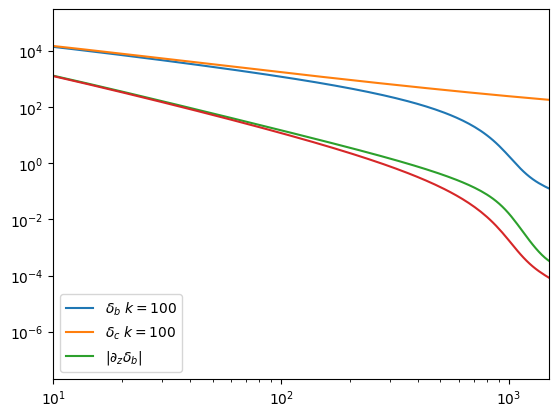

In [29]:
plt.plot(Z,ev[2,:,0],label='$\\delta_b$ $k=100$')
plt.plot(Z,ev[2,:,1],label='$\\delta_c$ $k=100$')
plt.plot(Z,abs(np.gradient(ev[2,:,0],Z)),label='$|\\partial_z \\delta_b|$')
plt.plot(Z,ev[2,:,0]/(1+Z))
plt.xscale('log')
plt.xlim(10,1500)
plt.yscale('log')
plt.legend()

In [30]:
plt.plot(Z,ev[4,:,0],label='$\\delta_b$ $k=300$')
plt.plot(Z,ev[4,:,1],label='$\\delta_c$ $k=300$')
plt.plot(Z,abs(np.gradient(ev[4,:,0],Z)),label='$|\\partial_z \\delta_b|$')
plt.plot(Z,ev[4,:,0]/(1+Z))
plt.xscale('log')
plt.xlim(10,1500)
plt.yscale('log')
plt.legend()

IndexError: index 4 is out of bounds for axis 0 with size 4

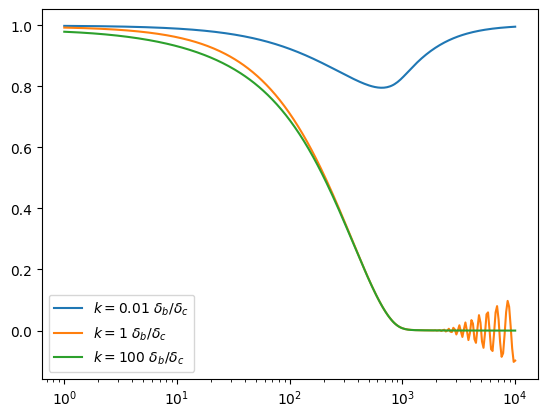

In [32]:
plt.plot(Z,ev[0,:,0]/ev[0,:,1],label='$k=0.01$ $\\delta_b/\\delta_c$')
plt.plot(Z,ev[1,:,0]/ev[1,:,1],label='$k=1$ $\\delta_b/\\delta_c$')
plt.plot(Z,ev[2,:,0]/ev[2,:,1],label='$k=100$ $\\delta_b/\\delta_c$')
plt.xscale('log')
plt.legend()

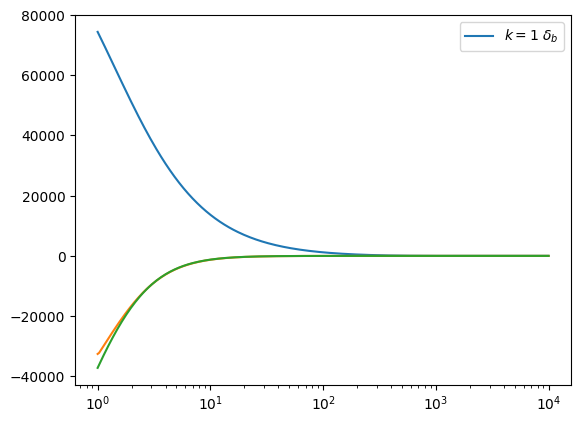

In [33]:
plt.plot(Z,ev[2,:,0],label='$k=1$ $\\delta_b$')
plt.plot(Z,np.gradient(ev[2,:,0],Z))
plt.plot(Z,-ev[2,:,0]/(1+Z))
plt.xscale('log')
plt.legend()

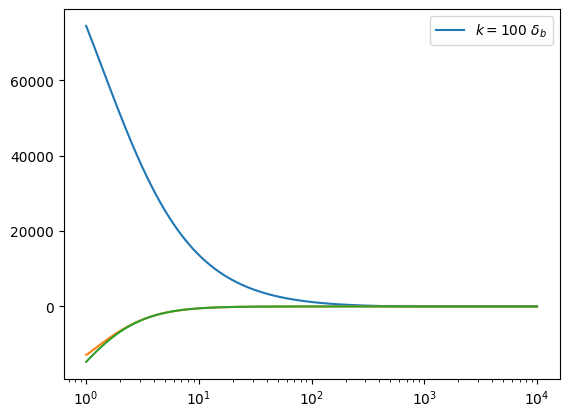

In [34]:
plt.plot(Z,ev[2,:,0],label='$k=100$ $\\delta_b$')
plt.plot(Z,np.gradient(ev[1,:,0],Z))
plt.plot(Z,-ev[1,:,0]/(1+Z))
plt.xscale('log')
plt.legend()

In [35]:
C1data=np.genfromtxt('C1data.csv', delimiter=',')
C1xdata=np.genfromtxt('C1xdata.csv', delimiter=',')

C1data_int=interpolate.interp1d(C1data[:,0],C1data[:,1],fill_value="extrapolate")
C1xdata_int=interpolate.interp1d(C1xdata[:,0],C1xdata[:,1],fill_value="extrapolate")

FileNotFoundError: C1data.csv not found.

In [36]:
dBdCk0=ev[0,:,0]/ev[0,:,1]
dBdCk1=ev[1,:,0]/ev[1,:,1]
dBdCk2=ev[2,:,0]/ev[2,:,1]
dBdCk3=ev[3,:,0]/ev[3,:,1]
dBdCk4=ev[4,:,0]/ev[4,:,1]
dBdCk5=ev[5,:,0]/ev[5,:,1]
C1data=C1int(Z)
#plt.plot(Z,dBdCk0,label='$k=0.01$')
plt.plot(Z,dBdCk1,label='$k=0.1$')
#plt.plot(Z,dBdCk1*C1data,label='$\Delta_T$ ????')
plt.plot(Z,dBdCk2,label='$k=1$')
plt.plot(Z,dBdCk3,label='$k=10$')
plt.plot(Z,dBdCk4,label='$k=100$')
plt.plot(Z,dBdCk5,label='$k=500$')
plt.xscale('log')
plt.xlim(15.5,2000)
plt.ylim(-0.2,1.2)
plt.ylabel('$\delta_b/\delta_c$')
plt.legend()


IndexError: index 4 is out of bounds for axis 0 with size 4

In [39]:
PKb = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=1000,
    var1='delta_baryon',var2='delta_baryon', zmax=1000)

In [41]:
PKcdm = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=1000,
    var1='delta_cdm',var2='delta_cdm', zmax=1000)

In [42]:
PKgamma = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=1000,
    var1='delta_photon',var2='delta_photon', zmax=1000)

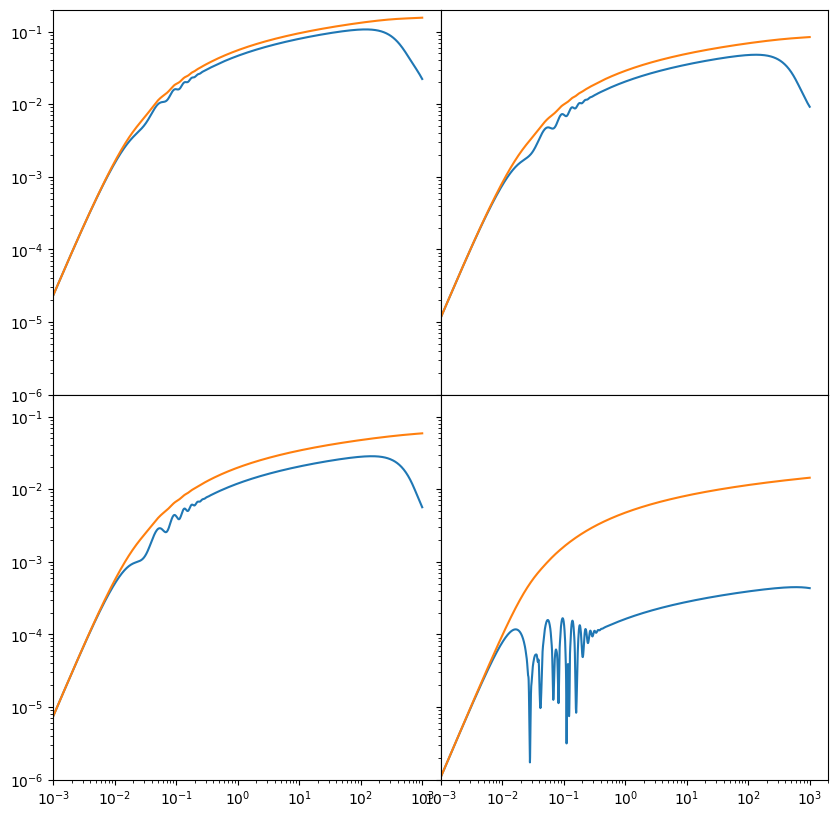

In [43]:
kval=10**np.linspace(-4,3,1000)
kvall=10**np.linspace(-4,3,3000)

kmin=1e-3
kmax=2e3

ymin=1e-6
ymax=0.2

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(10,10),sharex=True, sharey=True)

plt.subplots_adjust(wspace=0, hspace=0)

ax1.set_ylim(ymin,ymax)
ax1.set_xlim(kmin,kmax)
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.plot(kval,(kval**3*PKb.P(50,kval)/(2*np.pi**2))**0.5)
ax1.plot(kval,(kval**3*PKcdm.P(50,kval)/(2*np.pi**2))**0.5)
ax1.plot(kval,(kval**3*PKgamma.P(50,kval)/(2*np.pi**2))**0.5)

ax2.set_ylim(ymin,ymax)
ax2.set_xlim(kmin,kmax)
ax2.set_yscale('log')
ax2.set_xscale('log')

ax2.plot(kval,(kval**3*PKb.P(100,kval)/(2*np.pi**2))**0.5)
ax2.plot(kval,(kval**3*PKcdm.P(100,kval)/(2*np.pi**2))**0.5)
ax2.plot(kval,(kval**3*PKgamma.P(100,kval)/(2*np.pi**2))**0.5)

ax3.set_ylim(ymin,ymax)
ax3.set_xlim(kmin,kmax)
ax3.set_yscale('log')
ax3.set_xscale('log')

ax3.plot(kval,(kval**3*PKb.P(150,kval)/(2*np.pi**2))**0.5)
ax3.plot(kval,(kval**3*PKcdm.P(150,kval)/(2*np.pi**2))**0.5)
ax3.plot(kval,(kval**3*PKgamma.P(150,kval)/(2*np.pi**2))**0.5)

ax4.set_ylim(ymin,ymax)
ax4.set_xlim(kmin,kmax)
ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.plot(kvall,(kvall**3*PKb.P(800,kvall)/(2*np.pi**2))**0.5)
ax4.plot(kvall,(kvall**3*PKcdm.P(800,kvall)/(2*np.pi**2))**0.5)
ax4.plot(kvall,(kvall**3*PKgamma.P(800,kvall)/(2*np.pi**2))**0.5)

In [18]:
power50=np.column_stack((kval,(kval**3*PKb.P(50,kval)/(2*np.pi**2))**0.5,(kval**3*PKcdm.P(50,kval)/(2*np.pi**2))**0.5,(kval**3*PKgamma.P(50,kval)/(2*np.pi**2))**0.5))
power100=np.column_stack((kval,(kval**3*PKb.P(100,kval)/(2*np.pi**2))**0.5,(kval**3*PKcdm.P(100,kval)/(2*np.pi**2))**0.5,(kval**3*PKgamma.P(100,kval)/(2*np.pi**2))**0.5))
power150=np.column_stack((kval,(kval**3*PKb.P(150,kval)/(2*np.pi**2))**0.5,(kval**3*PKcdm.P(150,kval)/(2*np.pi**2))**0.5,(kval**3*PKgamma.P(150,kval)/(2*np.pi**2))**0.5))
power200=np.column_stack((kval,(kval**3*PKb.P(200,kval)/(2*np.pi**2))**0.5,(kval**3*PKcdm.P(200,kval)/(2*np.pi**2))**0.5,(kval**3*PKgamma.P(200,kval)/(2*np.pi**2))**0.5))
power800=np.column_stack((kvall,(kvall**3*PKb.P(800,kvall)/(2*np.pi**2))**0.5,(kvall**3*PKcdm.P(800,kvall)/(2*np.pi**2))**0.5,(kvall**3*PKgamma.P(800,kvall)/(2*np.pi**2))**0.5))
np.savetxt('power50.csv', power50, delimiter=',')
np.savetxt('power100.csv', power100, delimiter=',')
np.savetxt('power150.csv', power150, delimiter=',')
np.savetxt('power200.csv', power200, delimiter=',')
np.savetxt('power800.csv', power800, delimiter=',')


In [44]:
(kval**3*PKb.P(150,kval)/(2*np.pi**2))**0.5

array([7.83455607e-08, 8.08925964e-08, 8.35224325e-08, 8.62377606e-08,
       8.90413595e-08, 9.19360983e-08, 9.49249396e-08, 9.80109419e-08,
       1.01197264e-07, 1.04487165e-07, 1.07884013e-07, 1.11391284e-07,
       1.15012567e-07, 1.18751567e-07, 1.22612111e-07, 1.26598149e-07,
       1.30713760e-07, 1.34963155e-07, 1.39350682e-07, 1.43880832e-07,
       1.48558239e-07, 1.53387689e-07, 1.58374123e-07, 1.63522644e-07,
       1.68838517e-07, 1.74327183e-07, 1.79994256e-07, 1.85845533e-07,
       1.91887002e-07, 1.98124841e-07, 2.04565433e-07, 2.11215366e-07,
       2.18081442e-07, 2.25170685e-07, 2.32490346e-07, 2.40047912e-07,
       2.47851114e-07, 2.55907932e-07, 2.64226609e-07, 2.72815650e-07,
       2.81683842e-07, 2.90840254e-07, 3.00294248e-07, 3.10055492e-07,
       3.20133967e-07, 3.30539978e-07, 3.41284164e-07, 3.52377511e-07,
       3.63831359e-07, 3.75657418e-07, 3.87867778e-07, 4.00474920e-07,
       4.13491732e-07, 4.26931519e-07, 4.40808018e-07, 4.55135411e-07,
      

Text(0, 0.5, '$\\sim [k^3 P_i/2\\pi^2]^{1/2}$')

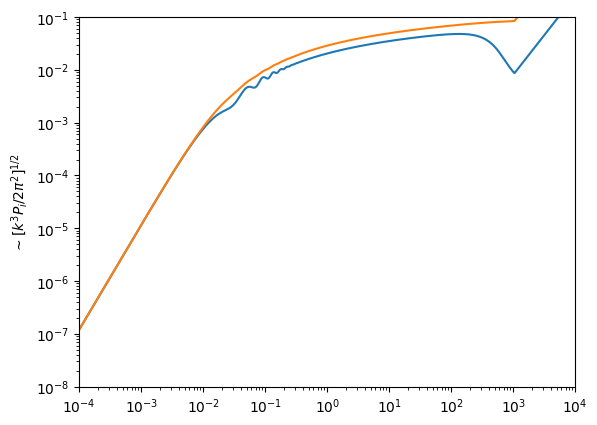

In [45]:
kval=10**np.linspace(-4,4,500)
plt.plot(kval,(kval**3*PKb.P(100,kval)/(2*np.pi**2))**0.5)
plt.plot(kval,(kval**3*PKcdm.P(100,kval)/(2*np.pi**2))**0.5)
plt.plot(kval,(kval**3*PKgamma.P(100,kval)/(2*np.pi**2))**0.5/16)
plt.xlim(1e-4,1e4)
plt.ylim(1e-8,0.1)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\\sim [k^3 P_i/2\\pi^2]^{1/2}$')

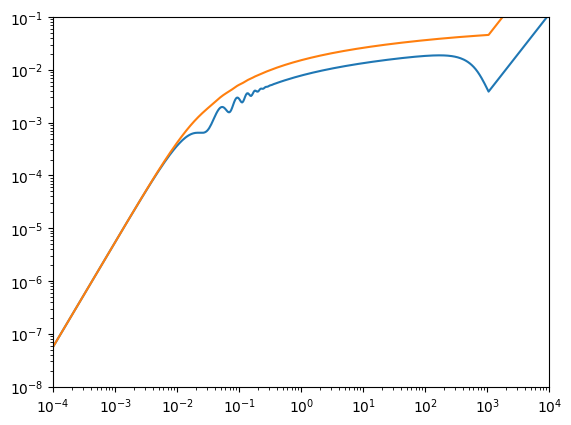

In [46]:
kval=10**np.linspace(-4,4,500)
plt.plot(kval,(kval**3*PKb.P(200,kval)/(2*np.pi**2))**0.5)
plt.plot(kval,(kval**3*PKcdm.P(200,kval)/(2*np.pi**2))**0.5)
plt.plot(kval,(kval**3*PKgamma.P(200,kval)/(2*np.pi**2))**0.5/16)
plt.xlim(1e-4,1e4)
plt.ylim(1e-8,0.1)
plt.xscale('log')
plt.yscale('log')

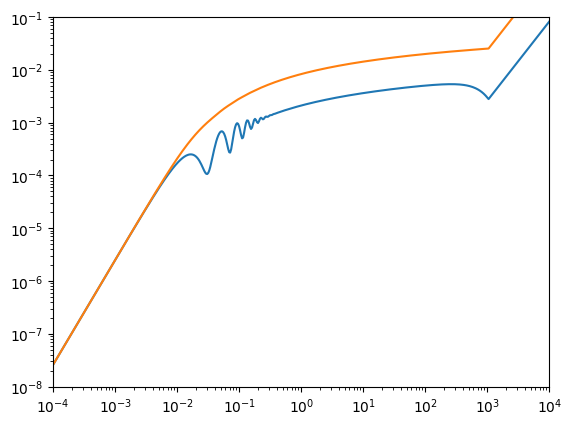

In [47]:
kval=10**np.linspace(-4,4,500)
plt.plot(kval,(kval**3*PKb.P(400,kval)/(2*np.pi**2))**0.5)
plt.plot(kval,(kval**3*PKcdm.P(400,kval)/(2*np.pi**2))**0.5)
plt.plot(kval,(kval**3*PKgamma.P(400,kval)/(2*np.pi**2))**0.5/16)
plt.xlim(1e-4,1e4)
plt.ylim(1e-8,0.1)
plt.xscale('log')
plt.yscale('log')

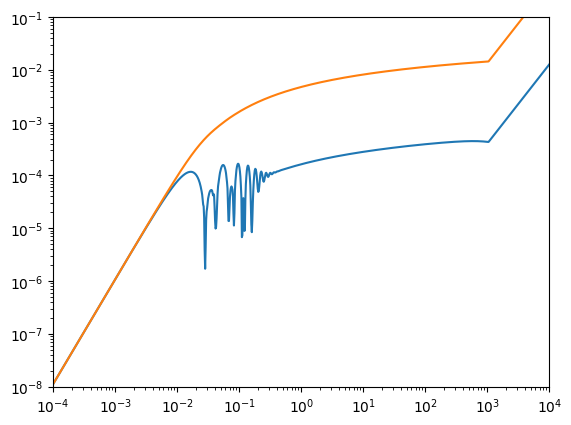

In [48]:
kval=10**np.linspace(-4,4,1000)
plt.plot(kval,(kval**3*PKb.P(800,kval)/(2*np.pi**2))**0.5)
plt.plot(kval,(kval**3*PKcdm.P(800,kval)/(2*np.pi**2))**0.5)
plt.plot(kval,(kval**3*PKgamma.P(800,kval)/(2*np.pi**2))**0.5/16)
plt.xlim(1e-4,1e4)
plt.ylim(1e-8,0.1)
plt.xscale('log')
plt.yscale('log')

In [49]:
cxedata = np.genfromtxt('xecoeff.csv', delimiter=',')
zxe=cxedata[:,0]
CaB=cxedata[:,1]
CT=cxedata[:,2]
Cn=cxedata[:,3]
Cxe=cxedata[:,4]


FileNotFoundError: xecoeff.csv not found.

In [48]:
CaB_int=interpolate.interp1d(zxe, CaB, fill_value="extrapolate")
CT_int=interpolate.interp1d(zxe, CT, fill_value="extrapolate")
Cn_int=interpolate.interp1d(zxe, Cn, fill_value="extrapolate")
Cxe_int=interpolate.interp1d(zxe, Cxe, fill_value="extrapolate")

In [49]:
A123data = np.genfromtxt('A123data.csv', delimiter=',')
zddd=A123data[:,0]
A1_int=interpolate.interp1d(zddd, A123data[:,1], fill_value="extrapolate")
A2_int=interpolate.interp1d(zddd, A123data[:,2], fill_value="extrapolate")
A3_int=interpolate.interp1d(zddd, A123data[:,3], fill_value="extrapolate")

In [50]:
def modelCax(C,aa):
    #initialize C coefficients
    C1=C[0]
    C2=C[1]
    C3=C[2]               #C3 is C2' in Eq. 13 of 1506.04152
    C4=C[3]
    C5=C[4]
    C6=C[5]
    
    #initialize D coefficients
    D1=C[6]
    D2=C[7]
    D3=C[8]
    D4=C[9]
    D5=C[10]
    D6=C[11]
    
    #evolution of C coefficients 
    dC1da=(-(1+ratc(zofa(aa)))/aa*C1
           +(ratc(zofa(aa))-Gamma_cHc(zofa(aa)))*D1/aa
           +2/(3*aa))
    
    dC2da=(-(2+ratc(zofa(aa)))/aa*C2
           +2/(3*aa)*(C1-1)
           +(ratc(zofa(aa))-Gamma_cHc(zofa(aa)))*D2/aa
           -Gamma_cHc(zofa(aa))*C1*D1/aa
          )
    
    dC3da=(-(2+ratc(zofa(aa)))/aa*C3
           +(ratc(zofa(aa))-Gamma_cHc(zofa(aa)))*D3/aa
           +4/(3*aa)
          )
    
    dC4da=(-(3+ratc(zofa(aa)))/aa*C4
           +2/(3*aa)*(1-C1+C2)
           +(ratc(zofa(aa))-Gamma_cHc(zofa(aa)))*D4/aa
           -Gamma_cHc(zofa(aa))*(C1*D2+C2*D1)/aa
          )
    
    dC5da=(-(3+ratc(zofa(aa)))/aa*C5
           +2/(3*aa)*(-3+2*C1+C3)
           +(ratc(zofa(aa))-Gamma_cHc(zofa(aa)))*D5/aa
           -Gamma_cHc(zofa(aa))*(C1*D3+C3*D1)/aa
          )
    
    dC6da=(-(3+ratc(zofa(aa)))/aa*C6
           +(ratc(zofa(aa))-Gamma_cHc(zofa(aa)))*D6/aa
           +2/aa
          )
    
    
    #evolution of D coefficients 
    dD1da=(-D1/aa
           -1/aa*Gamma_rHc(zofa(aa))*(A1_int(zofa(aa))*C1
                                      +D1
                                      +1
                                     )
          )
    
    dD2da=(-2*D2/aa
           -1/aa*Gamma_rHc(zofa(aa))*(D2
                                      +D1**2
                                      +A1_int(zofa(aa))*C2
                                      +A2_int(zofa(aa))*C1**2
                                      +2*A1_int(zofa(aa))*C1*D1
                                      +A1_int(zofa(aa))*C1
                                      +2*D1
                                     )
          )
    
    dD3da=(-2*D3/aa
           -1/aa*Gamma_rHc(zofa(aa))*(D3
                                      +A1_int(zofa(aa))*C3 #HERE IS A TYPO?! WAS C1!!!!
                                      +1
                                     )
          )
    
    dD4da=(-1/aa*(3+Gamma_rHc(zofa(aa)))*D4
           -1/aa*Gamma_rHc(zofa(aa))*(2*D1*D2
                                      +A1_int(zofa(aa))*C4
                                      +2*A2_int(zofa(aa))*C1*C2
                                      +A3_int(zofa(aa))*C1**3
                                      +2*A1_int(zofa(aa))*(D1*C2+D2*C1)
                                      +2*A2_int(zofa(aa))*D1*C1**2
                                      +A1_int(zofa(aa))*D1**2*C1
                                      +A1_int(zofa(aa))*C2
                                      +A2_int(zofa(aa))*C1**2
                                      +2*D2
                                      +D1**2
                                      +2*A1_int(zofa(aa))*D1*C1
                                     )
          )
    
    dD5da=(-1/aa*(3+Gamma_rHc(zofa(aa)))*D5
           -1/aa*Gamma_rHc(zofa(aa))*(2*D1*D3
                                      +A1_int(zofa(aa))*C5
                                      +2*A2_int(zofa(aa))*C1*C3
                                      +2*A1_int(zofa(aa))*(D1*C3+C1*D3)
                                      +A1_int(zofa(aa))*C1
                                      +A1_int(zofa(aa))*C3
                                      +2*D3
                                      +2*D1
                                     )
          )
    
    dD6da=(-1/aa*(3+Gamma_rHc(zofa(aa)))*D6
           -1/aa*Gamma_rHc(zofa(aa))*(A1_int(zofa(aa))*C6+1)
          )
    
        
    return [dC1da, dC2da, dC3da, dC4da, dC5da, dC6da, dD1da, dD2da, dD3da, dD4da, dD5da, dD6da] 

In [51]:
def modelCax1(C,aa):
    C1=C[0]
    C2=C[1]
    C3=C[2]               #C3 is C2' in Eq. 13 of 1506.04152
    C4=C[3]
    C5=C[4]
    C6=C[5]
    Cx=C[6]
    
    dC1da=(ratc(zofa(aa))-Gamma_cHc(zofa(aa)))*Cx/aa-(1+ratc(zofa(aa)))/aa*C1+2/(3*aa)
    dC2da=-(2+ratc(zofa(aa)))/aa*C2+2/(3*aa)*(C1-1-3/2*Gamma_cHc(zofa(aa))*Cx*C1)
    dC3da=-(2+ratc(zofa(aa)))/aa*C3+4/(3*aa)
    dC4da=-(3+ratc(zofa(aa)))/aa*C4+2/(3*aa)*(1-C1+C2-3/2*Gamma_cHc(zofa(aa))*C2*Cx)
    dC5da=-(3+ratc(zofa(aa)))/aa*C5+2/(3*aa)*(-3+2*C1+C3-3/2*Gamma_cHc(zofa(aa))*C3*Cx)
    dC6da=-(3+ratc(zofa(aa)))/aa*C6+2/aa
    dCxda=-Cx/aa-Gamma_rHc(zofa(aa))*(A1_int(zofa(aa))*C1+Cx+1)/aa
        
    return [dC1da, dC2da, dC3da, dC4da, dC5da, dC6da, dCxda] 

In [52]:
def modelCa(C,aa):
    
    C1=C[0]
    C2=C[1]
    C3=C[2]               #C3 is C2' in Eq. 13 of 1506.04152
    C4=C[3]
    C5=C[4]
    C6=C[5]
    
    dC1da=-(1+ratc(zofa(aa)))/aa*C1+2/(3*aa)           #WITH CUTOFF
    dC2da=-(2+ratc(zofa(aa)))/aa*C2+2/(3*aa)*(C1-1)
    dC3da=-(2+ratc(zofa(aa)))/aa*C3+4/(3*aa)
    dC4da=-(3+ratc(zofa(aa)))/aa*C4+2/(3*aa)*(1-C1+C2)
    dC5da=-(3+ratc(zofa(aa)))/aa*C5+2/(3*aa)*(-3+2*C1+C3)
    dC6da=-(3+ratc(zofa(aa)))/aa*C6+2/aa
    
    return [dC1da, dC2da, dC3da, dC4da, dC5da, dC6da]

In [51]:
def modelCatest(C,aa):
    
    C1=C[0]
    C2=C[1]
    C3=C[2]               #C3 is C2' in Eq. 13 of 1506.0415
    
    dC1da=-(1+ratc(zofa(aa)))/aa*C1+2/(3*aa)           #WITH CUTOFF
    dC2da=-(2+ratc(zofa(aa)))/aa*C2+2/(3*aa)*(C1-1)
    dC3da=-(2+ratc(zofa(aa)))/aa*C3+4/(3*aa)
    
    return [dC1da, dC2da, dC3da]

t = np.linspace(0.001,10000)
cini = [0.0,0.0,0.0]
sol = odeint(modelCatest,cini,t)

In [ ]:
plt.plot(zofa(t),sol)
plt.xlim(5,500)


In [53]:
#compute C-coefficients without electron fraction perturbations
t=np.linspace(0.001,1,10000)
Cini=[0.0,0.0,0.0,0.0,0.0,0.0]
Cdat=odeint(modelCa,Cini,t)

In [ ]:
#compute C-coefficients with electron fraction perturbations to third order
t=np.linspace(0.001,1,10000)
Cxini=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Cdatx=odeint(modelCax,Cxini,t)

In [15]:
#compute C-coefficients with electron fraction perturbations to first order
Cx1ini=[0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Cdatx1=odeint(modelCax1,Cx1ini,t)


/Users/timdewild/opt/anaconda3/envs/py37forge/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/timdewild/opt/anaconda3/envs/py37forge/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/timdewild/opt/anaconda3/envs/py37forge/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/timdewild/opt/anaconda3/envs/py37forge/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/timdewild/opt/anaconda3/envs/py37forge/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/timdewild/opt/anaconda3/envs/py3

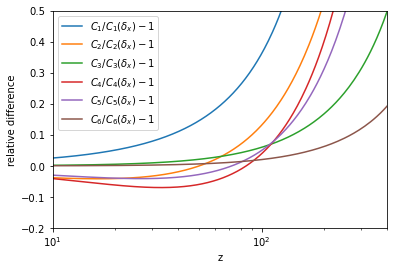

In [16]:
plt.plot(zofa(t),Cdat[:,0]/Cdatx[:,0]-1,label='$C_1/C_1(\delta_x)-1$')
plt.plot(zofa(t),Cdat[:,1]/Cdatx[:,1]-1,label='$C_2/C_2(\delta_x)-1$')
plt.plot(zofa(t),Cdat[:,2]/Cdatx[:,2]-1,label='$C_3/C_3(\delta_x)-1$')
plt.plot(zofa(t),Cdat[:,3]/Cdatx[:,3]-1,label='$C_4/C_4(\delta_x)-1$')
plt.plot(zofa(t),Cdat[:,4]/Cdatx[:,4]-1,label='$C_5/C_5(\delta_x)-1$')
plt.plot(zofa(t),Cdat[:,5]/Cdatx[:,5]-1,label='$C_6/C_6(\delta_x)-1$')
plt.xscale('log')
plt.xlim(10,400)
plt.ylim(-0.2,0.5)
plt.xlabel('z')
plt.ylabel('relative difference')
plt.legend()
#plt.savefig("reldiffx.png", dpi=300)

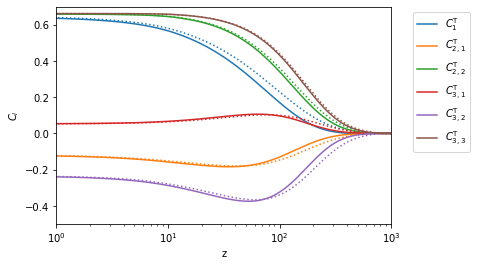

In [61]:
#plot C4
plt.plot(zofa(t),Cdatx[:,0],label='$C^\\mathrm{T}_1$',color='tab:blue')
plt.plot(zofa(t),Cdat[:,0],color='tab:blue',linestyle='dotted')

plt.plot(zofa(t),Cdatx[:,1],label='$C^\\mathrm{T}_{2,1}$',color='tab:orange')
plt.plot(zofa(t),Cdat[:,1],color='tab:orange',linestyle='dotted')

plt.plot(zofa(t),Cdatx[:,2],label='$C^\\mathrm{T}_{2,2}$',color='tab:green')
plt.plot(zofa(t),Cdat[:,2],color='tab:green',linestyle='dotted')

plt.plot(zofa(t),Cdatx[:,3],label='$C^\\mathrm{T}_{3,1}$',color='tab:red')
plt.plot(zofa(t),Cdat[:,3],color='tab:red',linestyle='dotted')

plt.plot(zofa(t),Cdatx[:,4],label='$C^\\mathrm{T}_{3,2}$',color='tab:purple')
plt.plot(zofa(t),Cdat[:,4],color='tab:purple',linestyle='dotted')

plt.plot(zofa(t),Cdatx[:,5],label='$C^\\mathrm{T}_{3,3}$',color='tab:brown')
plt.plot(zofa(t),Cdat[:,5],color='tab:brown',linestyle='dotted')

plt.xscale('log')
plt.xlim(1,1000)
plt.ylim(-0.5,0.7)
plt.xlabel('z')
plt.ylabel('$C_{i}$')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("C123456x.png", dpi=300,bbox_inches='tight')
plt.show()


In [55]:
C1int=interpolate.interp1d(zofa(t),Cdatx[:,0],fill_value="extrapolate")
C2int=interpolate.interp1d(zofa(t),Cdatx[:,1],fill_value="extrapolate")
C3int=interpolate.interp1d(zofa(t),Cdatx[:,2],fill_value="extrapolate")
C4int=interpolate.interp1d(zofa(t),Cdatx[:,3],fill_value="extrapolate")
C5int=interpolate.interp1d(zofa(t),Cdatx[:,4],fill_value="extrapolate")
C6int=interpolate.interp1d(zofa(t),Cdatx[:,5],fill_value="extrapolate")

D1int=interpolate.interp1d(zofa(t),Cdatx[:,6],fill_value="extrapolate")
D2int=interpolate.interp1d(zofa(t),Cdatx[:,7],fill_value="extrapolate")
D3int=interpolate.interp1d(zofa(t),Cdatx[:,8],fill_value="extrapolate")
D4int=interpolate.interp1d(zofa(t),Cdatx[:,9],fill_value="extrapolate")
D5int=interpolate.interp1d(zofa(t),Cdatx[:,10],fill_value="extrapolate")
D6int=interpolate.interp1d(zofa(t),Cdatx[:,11],fill_value="extrapolate")

C1int_nox=interpolate.interp1d(zofa(t),Cdat[:,0],fill_value="extrapolate")
C2int_nox=interpolate.interp1d(zofa(t),Cdat[:,1],fill_value="extrapolate")
C3int_nox=interpolate.interp1d(zofa(t),Cdat[:,2],fill_value="extrapolate")
C4int_nox=interpolate.interp1d(zofa(t),Cdat[:,3],fill_value="extrapolate")
C5int_nox=interpolate.interp1d(zofa(t),Cdat[:,4],fill_value="extrapolate")
C6int_nox=interpolate.interp1d(zofa(t),Cdat[:,5],fill_value="extrapolate")



In [60]:
zC=10**np.linspace(1,3,200)

CTxdata=np.column_stack((zC,C1int(zC),C2int(zC),C3int(zC),C4int(zC),C5int(zC),C6int(zC)))
CTdata=np.column_stack((zC,C1int_nox(zC),C2int_nox(zC),C3int_nox(zC),C4int_nox(zC),C5int_nox(zC),C6int_nox(zC)))

np.savetxt('CTxdata.csv', CTxdata, delimiter=',')
np.savetxt('CTdata.csv', CTdata, delimiter=',')

array([[ 1.00000000e+01,  5.66230696e-01, -1.57466655e-01, ...,
         6.65678202e-02, -2.87300571e-01,  6.57504426e-01],
       [ 1.02341140e+01,  5.64419849e-01, -1.58096144e-01, ...,
         6.69331342e-02, -2.88444162e-01,  6.57255306e-01],
       [ 1.04737090e+01,  5.62566072e-01, -1.58728168e-01, ...,
         6.73058686e-02, -2.89603505e-01,  6.56989273e-01],
       ...,
       [ 9.54771611e+02, -1.10940122e-04, -8.85743564e-07, ...,
         9.62539677e-07, -3.77358633e-06, -4.39699712e-06],
       [ 9.77124154e+02, -5.48722023e-05, -4.38098489e-07, ...,
         4.76082690e-07, -1.86645722e-06, -2.17480304e-06],
       [ 1.00000000e+03,  2.50834647e-06,  2.00265846e-08, ...,
        -2.17629380e-08,  8.53204571e-08,  9.94157206e-08]])

In [19]:
def Sigmax21(z):
    return -Gamma_rHc(z)/aofz(z)*(D1int(z)*(D1int(z)+2)+A1_int(z)*C1int(z)*(1+2*D1int(z))+A2_int(z)*C1int(z)**2)

def Sigmax32(z):
    return -Gamma_rHc(z)/aofz(z)*(2*D3int(z)*(1+D1int(z))+2*D1int(z)+A1_int(z)*C1int(z)*(1+2*D3int(z))
                                  +A1_int(z)*C3int(z)*(1+2*D1int(z))+2*A2_int(z)*C1int(z)*C3int(z)
                                 )

def Sigmax31(z):
    return -Gamma_rHc(z)/aofz(z)*(2*D2int(z)*(1+D1int(z))
                                  +D1int(z)**2
                                  +A1_int(z)*C2int(z)*(1+2*D1int(z)**2)
                                  +A1_int(z)*C1int(z)*(D1int(z)**2+2*D2int(z)+2*D1int(z))
                                  +A2_int(z)*C1int(z)**2*(1+2*D1int(z))
                                  +2*A2_int(z)*C1int(z)*C2int(z)
                                  +A3_int(z)*C1int(z)**3
                                 )

def SigmaT21(z):
    return 2/(3*aofz(z))*(C1int(z)-1)-Gamma_cHc(z)/aofz(z)*C1int(z)*D1int(z)

def SigmaT31(z):
    return 2/(3*aofz(z))*(1-C1int(z)+C2int(z))-Gamma_cHc(z)/aofz(z)*(C1int(z)*D2int(z)+C2int(z)*D1int(z))

def SigmaT32(z):
    return 2/(3*aofz(z))*(-3+2*C1int(z)+C3int(z))-Gamma_cHc(z)/aofz(z)*(C1int(z)*D3int(z)+C3int(z)*D1int(z))



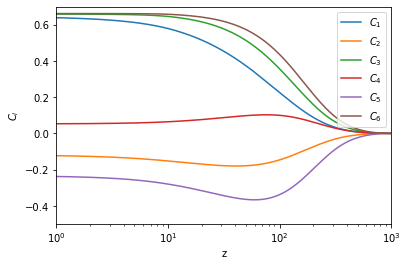

In [18]:
#plot C4
plt.plot(zofa(t),Cdat[:,0],label='$C_1$')
plt.plot(zofa(t),Cdat[:,1],label='$C_2$')
plt.plot(zofa(t),Cdat[:,2],label='$C_3$')
plt.plot(zofa(t),Cdat[:,3],label='$C_4$') 
plt.plot(zofa(t),Cdat[:,4],label='$C_5$')
plt.plot(zofa(t),Cdat[:,5],label='$C_6$')
plt.xscale('log')
plt.xlim(1,1000)
plt.ylim(-0.5,0.7)
plt.xlabel('z')
plt.ylabel('$C_{i}$')
plt.legend()
plt.savefig("C123456.png", dpi=300)
plt.show()

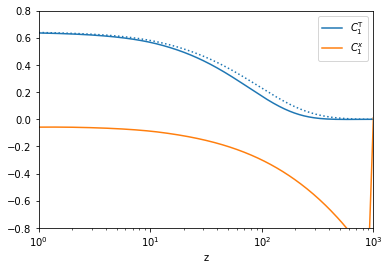

In [69]:
#plot C4
plt.plot(zz,C1int(zz),label='$C^\\mathrm{T}_{1}$',color='tab:blue')
plt.plot(zz,C1int_nox(zz),color='tab:blue',linestyle='dotted')
plt.plot(zz,D1int(zz),label='$C^x_{1}$',color='tab:orange')
plt.xscale('log')
plt.xlim(1,1000)
plt.ylim(-0.8,0.8)
plt.xlabel('z')
#plt.ylabel('$C_{i}$')
plt.legend()
plt.savefig("C1comp.png", dpi=300)
plt.show()

In [76]:
LALA=np.column_stack((zC,C1int(zC),C1int_nox(zC),D1int(zC)))
np.savetxt('CTCx.csv', LALA, delimiter=',')

LALA2=np.column_stack((zC[0:-30],D1int(zC)[0:-30]))
np.savetxt('Cx.csv', LALA2, delimiter=',')

In [75]:
D1int(zC)[0:-30]

array([-0.08731272, -0.08816033, -0.08902738, -0.08991431, -0.09082157,
       -0.09176368, -0.09274472, -0.09374997, -0.09477482, -0.09581815,
       -0.09687871, -0.09795569, -0.09904933, -0.1001599 , -0.10128766,
       -0.10243287, -0.1035958 , -0.10477673, -0.10597595, -0.1071937 ,
       -0.10843031, -0.10968604, -0.11096119, -0.11225606, -0.11357095,
       -0.11490616, -0.11626201, -0.1176388 , -0.11903685, -0.1204565 ,
       -0.12189806, -0.12336185, -0.12484823, -0.12635752, -0.12789007,
       -0.12944622, -0.13102634, -0.13263076, -0.13425986, -0.13591399,
       -0.13759352, -0.13929885, -0.14103033, -0.14278834, -0.1445733 ,
       -0.14638554, -0.14822551, -0.15009359, -0.15199021, -0.15391574,
       -0.15587058, -0.15785517, -0.15986994, -0.16191533, -0.16399174,
       -0.16609957, -0.16823932, -0.17041142, -0.17261632, -0.17485443,
       -0.17712619, -0.17943217, -0.18177271, -0.18414829, -0.18655944,
       -0.1890066 , -0.19149026, -0.19401094, -0.19656894, -0.19

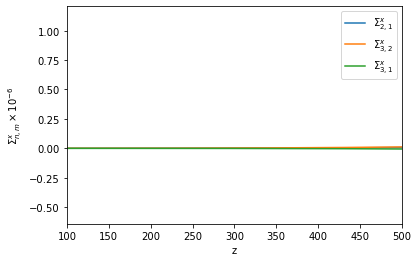

In [91]:
#plot C4
zlin=np.linspace(0,1000,1000)
plt.plot(zlin,Sigmax21(zlin)/10**5,label='$\Sigma^x_{2,1}$')
plt.plot(zlin,Sigmax32(zlin)/10**5,label='$\Sigma^x_{3,2}$')
plt.plot(zlin,Sigmax31(zlin)/10**5,label='$\Sigma^x_{3,1}$')

#plt.xscale('log')
plt.xlim(100,500)
plt.ylim(0.1,10**6)
plt.xlabel('z')
#plt.yscale('log')
plt.ylabel('$\Sigma^x_{n,m}\\times 10^{-6}$')
plt.legend()
plt.show()

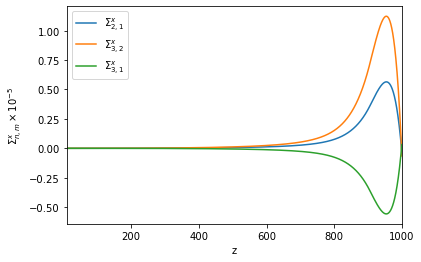

In [22]:
#plot C4
zlin=np.linspace(0,1000,10000)
plt.plot(zlin,(Sigmax21(zlin))/10**5,label='$\Sigma^x_{2,1}$')
plt.plot(zlin,(Sigmax32(zlin))/10**5,label='$\Sigma^x_{3,2}$')
plt.plot(zlin,(Sigmax31(zlin))/10**5,label='$\Sigma^x_{3,1}$')

#plt.xscale('log')
plt.xlim(10,1000)
#plt.ylim(0.1,10**6)
plt.xlabel('z')
#plt.yscale('log')
plt.ylabel('$\Sigma^x_{n,m}\\times 10^{-5} $')
plt.legend()
plt.savefig("Sigmax.png", dpi=300)
plt.show()

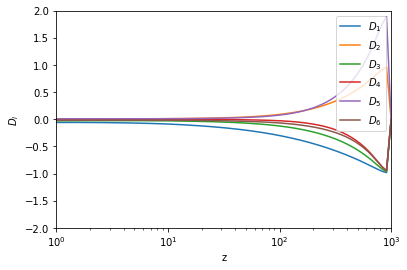

In [35]:
plt.plot(zofa(t),Cdatx[:,6],label='$D_1$')
plt.plot(zofa(t),Cdatx[:,7],label='$D_2$')
plt.plot(zofa(t),Cdatx[:,8],label='$D_3$')
plt.plot(zofa(t),Cdatx[:,9],label='$D_4$') 
plt.plot(zofa(t),Cdatx[:,10],label='$D_5$')
plt.plot(zofa(t),Cdatx[:,11],label='$D_6$')
plt.xscale('log')
plt.xlim(1,1000)
plt.ylim(-2,2)
plt.xlabel('z')
plt.ylabel('$D_{i}$')
plt.legend()
#plt.savefig("C123456.png", dpi=300)
plt.show()


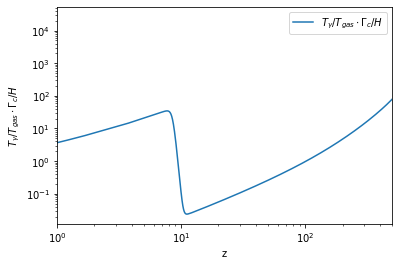

In [131]:
plt.plot(zofa(t),rat(zofa(t)),label='$T_\gamma/T_{gas}\cdot \Gamma_c/H$')
plt.xscale('log')
plt.xlim(1,500)
plt.yscale('log')
plt.xlabel('z')
plt.ylabel('$T_\gamma/T_{gas}\cdot \Gamma_c/H$')
plt.legend()
plt.show()

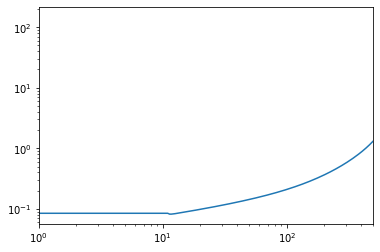

In [53]:
ZZ=10**np.linspace(0,3,200)
plt.plot(ZZ,Gamma_rHc(ZZ),label='$T_\gamma/T_{gas}\cdot \Gamma_c/H$ cutoff')
plt.xscale('log')
plt.xlim(1,500)
plt.yscale('log')

In [20]:
zdata=z
xedata=xe(z)
TmTgdata=TmTg(z)
dataoutput = np.column_stack((zdata,xedata,TmTgdata))
np.savetxt('zxeTmTg.csv', dataoutput, delimiter=',')

In [21]:
# col 0: zdata, 1: cHdata, 2: cTdata, 3: cHHdata, 4: cHTdata, 5: cTTdata, 6: cHHHdata, 7: cHHTdata, 8: cHTTdata, 9: cTTTdata
cdata = np.genfromtxt('T21coeff.csv', delimiter=',')
cz=cdata[:,0]
cH=cdata[:,1]
cT=cdata[:,2]
cHH=cdata[:,3]
cHT=cdata[:,4]
cTT=cdata[:,5]
cHHH=cdata[:,6]
cHHT=cdata[:,7]
cHTT=cdata[:,8]
cTTT=cdata[:,9]

In [22]:
# construct interpolators of coefficients
T_H=interpolate.interp1d(cz, cH, fill_value="extrapolate")
T_T=interpolate.interp1d(cz, cT, fill_value="extrapolate")
T_HH=interpolate.interp1d(cz, cHH, fill_value="extrapolate")
T_HT=interpolate.interp1d(cz, cHT, fill_value="extrapolate")
T_TT=interpolate.interp1d(cz, cTT, fill_value="extrapolate")
T_HHH=interpolate.interp1d(cz, cHHH, fill_value="extrapolate")
T_HHT=interpolate.interp1d(cz, cHHT, fill_value="extrapolate")
T_HTT=interpolate.interp1d(cz, cHTT, fill_value="extrapolate")
T_TTT=interpolate.interp1d(cz, cTTT, fill_value="extrapolate")


In [23]:
def alpha11(z):
    return T_T(z)*C1int(z)+T_H(z)

def alpha22(z):
    return T_T(z)*C3int(z)+T_H(z)

def alpha33(z):
    return T_T(z)*C6int(z)+T_H(z)

def alpha21(z):
    return T_T(z)*C2int(z)+T_TT(z)*C1int(z)**2+T_HT(z)*C1int(z)+T_HH(z)

def alpha31(z):
    return (T_T(z)*C4int(z)+2*T_TT(z)*C1int(z)*C2int(z)+T_HT(z)*C2int(z)
            +T_TTT(z)*C1int(z)**3+T_HTT(z)*C1int(z)**2+T_HHT(z)*C1int(z)+T_HHH(z))

def alpha32(z):
    return T_T(z)*C5int(z)+2*T_TT(z)*C1int(z)*C3int(z)+T_HT(z)*(C3int(z)+C1int(z))+2*T_HH(z)

def alpha11_nox(z):
    return T_T(z)*C1int_nox(z)+T_H(z)

def alpha22_nox(z):
    return T_T(z)*C3int_nox(z)+T_H(z)

def alpha33_nox(z):
    return T_T(z)*C6int_nox(z)+T_H(z)

def alpha21_nox(z):
    return T_T(z)*C2int_nox(z)+T_TT(z)*C1int_nox(z)**2+T_HT(z)*C1int_nox(z)+T_HH(z)

def alpha31_nox(z):
    return (T_T(z)*C4int_nox(z)+2*T_TT(z)*C1int_nox(z)*C2int_nox(z)+T_HT(z)*C2int_nox(z)
            +T_TTT(z)*C1int_nox(z)**3+T_HTT(z)*C1int_nox(z)**2+T_HHT(z)*C1int_nox(z)+T_HHH(z))

def alpha32_nox(z):
    return T_T(z)*C5int_nox(z)+2*T_TT(z)*C1int_nox(z)*C3int_nox(z)+T_HT(z)*(C3int_nox(z)+C1int_nox(z))+2*T_HH(z)


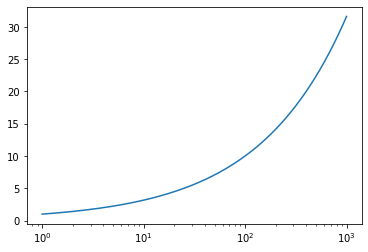

In [24]:
plt.plot(zz,np.sqrt(zz))
plt.xscale('log')


Text(0, 0.5, '$\\alpha_{n,n}$ (mK)')

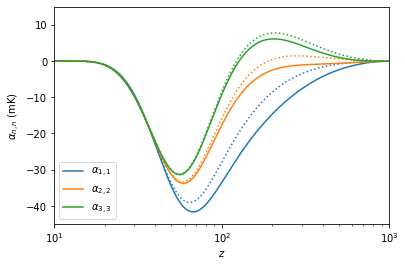

In [25]:
# plot alpha, beta, gamma
plt.plot(zz,alpha11(zz)*1000,label='$\\alpha_{1,1}$',color='tab:blue')
plt.plot(zz,alpha11_nox(zz)*1000,color='tab:blue',linestyle='dotted')

plt.plot(zz,alpha22(zz)*1000,label='$\\alpha_{2,2}$',color='tab:orange')
plt.plot(zz,alpha22_nox(zz)*1000,color='tab:orange',linestyle='dotted')

plt.plot(zz,alpha33(zz)*1000,label='$\\alpha_{3,3}$',color='tab:green')
plt.plot(zz,alpha33_nox(zz)*1000,color='tab:green',linestyle='dotted')

#plt.plot(zz,T21(zz)*1000,color='tab:red',linestyle='dotted',label='$T_{21}$')

#plt.plot(zofa(t),T21(zofa(t))*1000,label='$T_{21}$')
plt.legend()
plt.ylim(-45,15)
plt.xlim(10,1000)
plt.xscale('log')
plt.xlabel('$z$')
plt.ylabel('$\\alpha_{n,n}$ (mK)')

Text(0, 0.5, '$\\alpha_{n,m\\neq n}$ (mK)')

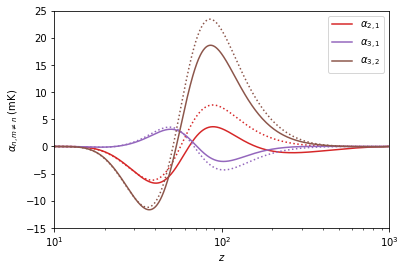

In [26]:
# plot alpha, beta, gamma
plt.plot(zz,alpha21(zz)*1000,label='$\\alpha_{2,1}$',color='tab:red')
plt.plot(zz,alpha21_nox(zz)*1000,color='tab:red',linestyle='dotted')

plt.plot(zz,alpha31(zz)*1000,label='$\\alpha_{3,1}$',color='tab:purple')
plt.plot(zz,alpha31_nox(zz)*1000,color='tab:purple',linestyle='dotted')

plt.plot(zz,alpha32(zz)*1000,label='$\\alpha_{3,2}$',color='tab:brown')
plt.plot(zz,alpha32_nox(zz)*1000,color='tab:brown',linestyle='dotted')

#plt.plot(zofa(t),T21(zofa(t))*1000,label='$T_{21}$')
plt.legend()
plt.ylim(-15,25)
plt.xlim(10,1000)
plt.xscale('log')
plt.xlabel('$z$')
plt.ylabel('$\\alpha_{n,m\\neq n}$ (mK)')

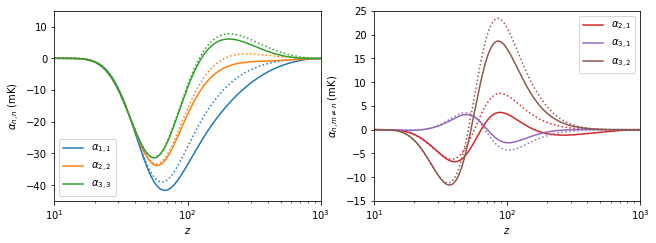

In [33]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10.5,3.5),sharey=False)
ax1.plot(zz,alpha11(zz)*1000,label='$\\alpha_{1,1}$',color='tab:blue')
ax1.plot(zz,alpha11_nox(zz)*1000,color='tab:blue',linestyle='dotted')

ax1.plot(zz,alpha22(zz)*1000,label='$\\alpha_{2,2}$',color='tab:orange')
ax1.plot(zz,alpha22_nox(zz)*1000,color='tab:orange',linestyle='dotted')

ax1.plot(zz,alpha33(zz)*1000,label='$\\alpha_{3,3}$',color='tab:green')
ax1.plot(zz,alpha33_nox(zz)*1000,color='tab:green',linestyle='dotted')

ax1.legend()
ax1.set_ylim(-45,15)
ax1.set_xlim(10,1000)
ax1.set_xscale('log')
ax1.set_xlabel('$z$')
ax1.set_ylabel('$\\alpha_{n,n}$ (mK)')

ax2.plot(zz,alpha21(zz)*1000,label='$\\alpha_{2,1}$',color='tab:red')
ax2.plot(zz,alpha21_nox(zz)*1000,color='tab:red',linestyle='dotted')

ax2.plot(zz,alpha31(zz)*1000,label='$\\alpha_{3,1}$',color='tab:purple')
ax2.plot(zz,alpha31_nox(zz)*1000,color='tab:purple',linestyle='dotted')

ax2.plot(zz,alpha32(zz)*1000,label='$\\alpha_{3,2}$',color='tab:brown')
ax2.plot(zz,alpha32_nox(zz)*1000,color='tab:brown',linestyle='dotted')

#plt.plot(zofa(t),T21(zofa(t))*1000,label='$T_{21}$')
ax2.legend()
ax2.set_ylim(-15,25)
ax2.set_xlim(10,1000)
ax2.set_xscale('log')
ax2.set_xlabel('$z$')
ax2.set_ylabel('$\\alpha_{n,m\\neq n}$ (mK)')

plt.savefig("alphacoeff3.png", dpi=300)

In [81]:
zzz=10**np.linspace(1,3,200)
coeffdata=np.column_stack((zzz,1000*alpha11(zzz),1000*alpha22(zzz),1000*alpha33(zzz),1000*alpha21(zzz),1000*alpha31(zzz),1000*alpha32(zzz)))
np.savetxt('alphacoeffdata.csv', coeffdata, delimiter=',')

In [82]:
coeffdatanox=np.column_stack((zzz,1000*alpha11_nox(zzz),1000*alpha22_nox(zzz),1000*alpha33_nox(zzz),1000*alpha21_nox(zzz),1000*alpha31_nox(zzz),1000*alpha32_nox(zzz)))
np.savetxt('alphacoeffdatanox.csv', coeffdatanox, delimiter=',')

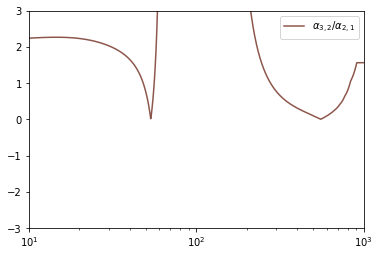

In [84]:
plt.plot(zz,abs(alpha32(zz))/abs(alpha21(zz)),label='$\\alpha_{3,2}/\\alpha_{2,1}$',color='tab:brown')
#plt.plot(zz,abs(alpha31(zz))/abs(alpha21(zz)),label='$\\alpha_{3,1}/\\alpha_{2,1}$',color='tab:brown')

plt.legend()
plt.ylim(-3,3)
plt.xlim(10,1000)
plt.xscale('log')

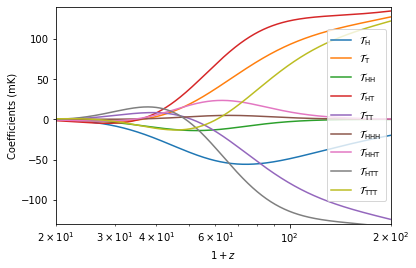

In [85]:
# plot coefficients T_H, T_T etc...
plt.plot(zz,1000*T_H(zz),label='$\\mathcal{T}_{\\rm{H}}$')
plt.plot(zz,1000*T_T(zz),label='$\\mathcal{T}_{\\rm{T}}$')
plt.plot(zz,1000*T_HH(zz),label='$\\mathcal{T}_{\\rm{HH}}$')
plt.plot(zz,1000*T_HT(zz),label='$\\mathcal{T}_{\\rm{HT}}$')
plt.plot(zz,1000*T_TT(zz),label='$\\mathcal{T}_{\\rm{TT}}$')
plt.plot(zz,1000*T_HHH(zz),label='$\\mathcal{T}_{\\rm{HHH}}$')
plt.plot(zz,1000*T_HHT(zz),label='$\\mathcal{T}_{\\rm{HHT}}$')
plt.plot(zz,1000*T_HTT(zz),label='$\\mathcal{T}_{\\rm{HTT}}$')
plt.plot(zz,1000*T_TTT(zz),label='$\\mathcal{T}_{\\rm{TTT}}$')
plt.xlim(20,200)
plt.xlabel('$1+z$')
plt.ylabel('Coefficients (mK)')
plt.ylim(-130,140)
plt.xscale('log')
plt.legend()
plt.show()

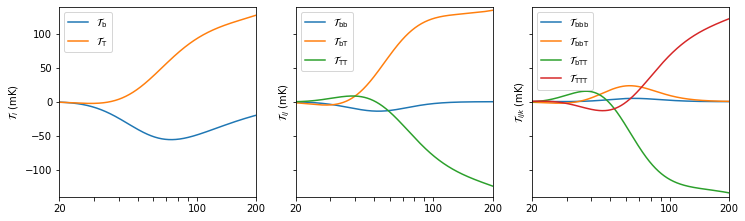

In [147]:
from matplotlib.ticker import FixedLocator

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=(12,3.5),sharey=True)

ax1.set_xlim(20,200)
ax1.set_ylim(-140,140)
ax1.set_xscale('log')
ax1.set_xticks([20,30,40,50,60,70,80,90,100,200])
ax1.set_xticklabels(['20','','','','','','','','100','200'])
ax1.set_ylabel('$\\mathcal{T}_i$ (mK)')
ax1.plot(zz,1000*T_H(zz),label='$\\mathcal{T}_{\\rm{b}}$')
ax1.plot(zz,1000*T_T(zz),label='$\\mathcal{T}_{\\rm{T}}$')
ax1.legend()

ax2.set_xlim(20,200)
ax2.set_ylim(-140,140)
ax2.set_xscale('log')
ax2.set_xticks([20,30,40,50,60,70,80,90,100,200])
ax2.set_xticklabels(['20','','','','','','','','100','200'])
ax2.set_ylabel('$\\mathcal{T}_{ij}$ (mK)')
ax2.plot(zz,1000*T_HH(zz),label='$\\mathcal{T}_{\\rm{bb}}$')
ax2.plot(zz,1000*T_HT(zz),label='$\\mathcal{T}_{\\rm{bT}}$')
ax2.plot(zz,1000*T_TT(zz),label='$\\mathcal{T}_{\\rm{TT}}$')
ax2.legend()

ax3.set_xlim(20,200)
ax3.set_ylim(-140,140)
ax3.set_xscale('log')
ax3.set_xticks([20,30,40,50,60,70,80,90,100,200])
ax3.set_xticklabels(['20','','','','','','','','100','200'])
ax3.set_ylabel('$\\mathcal{T}_{ijk}$ (mK)')
ax3.plot(zz,1000*T_HHH(zz),label='$\\mathcal{T}_{\\rm{bbb}}$')
ax3.plot(zz,1000*T_HHT(zz),label='$\\mathcal{T}_{\\rm{bbT}}$')
ax3.plot(zz,1000*T_HTT(zz),label='$\\mathcal{T}_{\\rm{bTT}}$')
ax3.plot(zz,1000*T_TTT(zz),label='$\\mathcal{T}_{\\rm{TTT}}$')
ax3.legend()

plt.savefig("Tijkcoeff.png", dpi=300)


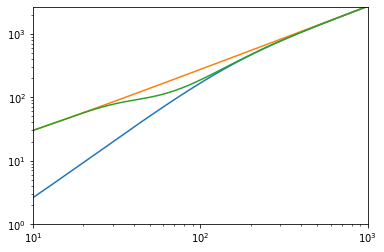

In [179]:
# plot Tm (gas), Tg (photons), Ts (spin)
plt.plot(z,Tm(z))
plt.plot(z,Tg(z))
plt.plot(z,Ts(z))
plt.xlim(10, 1000)
plt.ylim(1, 2.7e3)
plt.xscale('log')
plt.yscale('log')

In [27]:
zzz=10**np.linspace(1,3,100)
coeffdata=np.column_stack((zzz,1000*T_H(zzz),1000*T_T(zzz),1000*T_HH(zzz),1000*T_HT(zzz),1000*T_TT(zzz),1000*T_HHH(zzz),1000*T_HHT(zzz),1000*T_HTT(zzz),1000*T_TTT(zzz)))
np.savetxt('coeffdata.csv', coeffdata, delimiter=',')

In [99]:
c123data=np.column_stack((zzz,C1int(zzz),C2int(zzz),C3int(zzz)))
np.savetxt('c123data.csv',c123data,delimiter=',')

In [108]:
Tabcdata=np.column_stack((zzz,1000*T21(zzz),1000*alpha_int(zzz),1000*beta_int(zzz),1000*gamma_int(zzz)))
np.savetxt('Tabc.csv',Tabcdata,delimiter=',')

In [190]:
zspin=10**np.linspace(1,3,200)
Tspindata=np.column_stack((zspin,Tm(zspin),Tg(zspin),Ts(zspin),Yc(zspin)/10000))
np.savetxt('Tspin.csv', Tspindata, delimiter=',')

(0.0, 8.0)

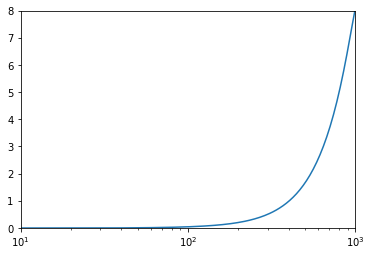

In [186]:
plt.plot(zspin,Yc(zspin)/100)
plt.xscale('log')
plt.xlim(10,1000)
plt.ylim(0,8)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 325
Traceback (most recent call last):
  File "/Users/timdewild/opt/anaconda3/envs/py37forge/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-231-192e051f255c>", line 3, in <module>
    plt.plot(zz,Gamma_rH(zz),label='$\Gamma_R/H$')
  File "<ipython-input-226-25562f36366c>", line 90, in Gamma_rH
    return Gamma_r(z)/H(z)
  File "<ipython-input-226-25562f36366c>", line 86, in Gamma_r
    return nH(z)*xe(z)*alphaB(z)
  File "<ipython-input-226-25562f36366c>", line 78, in alphaB
    return a_alpha*t(z)**b_rec/(1+c_rec*t(z)**d_rec) #in m3/s
TypeError: 'numpy.ndarray' object is not callable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/timdewild/opt/anaconda3/envs/py37forge/lib/python3.7/site-packages/IPython/core/

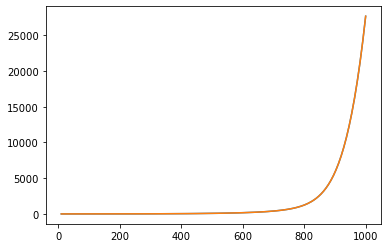

In [ ]:
plt.plot(zz,Gamma_cH(zz),label='$\Gamma_C/H$')
plt.plot(zz,Gamma_cHc(zz),label='$\Gamma_C/H$ cutoff')
plt.plot(zz,Gamma_rH(zz),label='$\Gamma_R/H$')
plt.plot(zz,Gamma_rHc(zz),label='$\Gamma_R/H$ cutoff')
#plt.plot(zz,1/C10(zz)*3.16887e-8)
#plt.plot(zz,Tstar/(A10*Tg(zz))*3.16887e-8)
#plt.plot(zz,Tm(zz))
#plt.plot(zz,Tg(zz))
#plt.plot(zz,Ts(zz))
plt.xlim(10,1000)
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [224]:
Gamma_rH(11)

0.35230137469635703

In [ ]:
Gamma_rH()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/timdewild/opt/anaconda3/envs/py37forge/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-231-8f7201033815>", line 1, in <module>
    Gamma_rH(11)
  File "<ipython-input-226-25562f36366c>", line 90, in Gamma_rH
    return Gamma_r(z)/H(z)
  File "<ipython-input-226-25562f36366c>", line 86, in Gamma_r
    return nH(z)*xe(z)*alphaB(z)
  File "<ipython-input-226-25562f36366c>", line 78, in alphaB
    return a_alpha*t(z)**b_rec/(1+c_rec*t(z)**d_rec) #in m3/s
TypeError: 'numpy.ndarray' object is not callable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/timdewild/opt/anaconda3/envs/py37forge/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no a